In [1]:
!uv pip install kagglehub

Using Python 3.11.6 environment at: /Users/nyeinchan/Desktop/time-series/.venv
Audited 1 package in 22ms


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import kagglehub

import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast.models import (
    HistoricAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    AutoARIMA,
    ARIMA,
    MSTL as MSTL_Model,
    AutoETS,
    AutoTBATS
)

from utilsforecast.losses import rmse, mae, smape
from utilsforecast.evaluation import evaluate

In [4]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

In [5]:
print(path)

/Users/nyeinchan/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


In [6]:
dataset = "COMED_hourly.csv"

df = pd.read_csv(f'{path}/{dataset}')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  str    
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), str(1)
memory usage: 2.2 MB


In [7]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

start - 2011-01-01 01:00:00	\
end - 2018-08-03 00:00:00	

In [8]:
df

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0
...,...,...
66492,2018-08-02 20:00:00,16437.0
66493,2018-08-02 21:00:00,15590.0
66494,2018-08-02 22:00:00,15086.0
66495,2018-08-02 23:00:00,14448.0


In [9]:
# statsforecast friendly
df['ds'] = pd.to_datetime(df['Datetime'])
df = df.rename(columns={'COMED_MW': 'y'})
df['unique_id'] = 'comed_hourly'
df = df[['unique_id', 'ds', 'y']]

In [10]:
df

,unique_id,ds,y
0,comed_hourly,2011-01-01 01:00:00,9631.0
1,comed_hourly,2011-01-01 02:00:00,9273.0
2,comed_hourly,2011-01-01 03:00:00,9011.0
3,comed_hourly,2011-01-01 04:00:00,8741.0
4,comed_hourly,2011-01-01 05:00:00,8694.0
...,...,...,...
66492,comed_hourly,2018-08-02 20:00:00,16437.0
66493,comed_hourly,2018-08-02 21:00:00,15590.0
66494,comed_hourly,2018-08-02 22:00:00,15086.0
66495,comed_hourly,2018-08-02 23:00:00,14448.0


#### Null and duplication checks

In [11]:
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

In [12]:
df[df['ds'].duplicated(keep=False)].sort_values('ds')

,unique_id,ds,y
33618,comed_hourly,2014-11-02 02:00:00,9184.0
33619,comed_hourly,2014-11-02 02:00:00,8869.0
42354,comed_hourly,2015-11-01 02:00:00,8270.0
42355,comed_hourly,2015-11-01 02:00:00,7923.0
51258,comed_hourly,2016-11-06 02:00:00,8028.0
51259,comed_hourly,2016-11-06 02:00:00,7814.0
59994,comed_hourly,2017-11-05 02:00:00,8198.0
59995,comed_hourly,2017-11-05 02:00:00,7878.0


average the duplicated Fall back times

In [13]:
dst_times = [
    "2014-11-02 02:00:00",
    "2015-11-01 02:00:00",
    "2016-11-06 02:00:00",
    "2017-11-05 02:00:00",
]

for t in dst_times:
    t = pd.Timestamp(t)

    rows = df[df['ds'] == t]

    combined_y = rows['y'].sum() / 2

    # keep the first row
    keep_idx = rows.index[0]
    drop_idx = rows.index[1]

    df.loc[keep_idx, 'y'] = combined_y
    df = df.drop(drop_idx)

In [14]:
df.info()   # 66493 rows

<class 'pandas.DataFrame'>
Index: 66493 entries, 0 to 66496
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  66493 non-null  str           
 1   ds         66493 non-null  datetime64[us]
 2   y          66493 non-null  float64       
dtypes: datetime64[us](1), float64(1), str(1)
memory usage: 2.8 MB


#check data distribution

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['y'], bins=100, color='steelblue', edgecolor='none')
axes[0].set_title('Raw y distribution')
axes[0].set_xlabel('MW')

axes[1].hist(np.log1p(df['y']), bins=100, color='coral', edgecolor='none')
axes[1].set_title('log1p(y) distribution')
axes[1].set_xlabel('log1p(MW)')

plt.tight_layout()
plt.show()

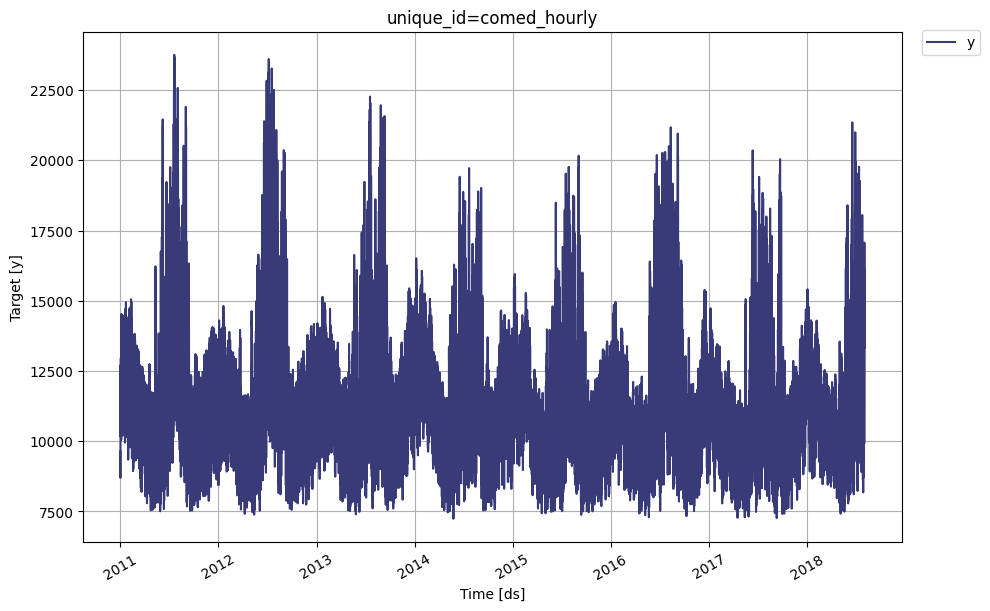

In [15]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


USA Seasons
- Spring `(March-May)` [03-05]
- Summer `(June-Aug)` [06-08]
- Fall `(Sep-Nov)` [09-11]
- Winter `(Dec-Feb)` [12-02]

Some simple findings
- clear baseline around ~11,000
- spikes up to around +23,000 during summer
- clear yearly seasonal pattern

In [16]:
# because of DST there can be still some skipped times
# even if i averaged some results in above we still have
# to consider about spring forward day
hourly_date_range = pd.date_range(
    start=df['ds'].min(),
    end=df['ds'].max(),
    freq='h'
)

skipped_hours = hourly_date_range.difference(df['ds'])
print(len(skipped_hours), skipped_hours)

11 DatetimeIndex(['2011-03-13 03:00:00', '2011-11-06 02:00:00',
               '2012-03-11 03:00:00', '2012-11-04 02:00:00',
               '2013-03-10 03:00:00', '2013-11-03 02:00:00',
               '2014-03-09 03:00:00', '2015-03-08 03:00:00',
               '2016-03-13 03:00:00', '2017-03-12 03:00:00',
               '2018-03-11 03:00:00'],
              dtype='datetime64[us]', freq=None)


01:00 → 02:00 → [clocks jump] → 03:00

In [17]:
df[df['ds'] == '2011-03-13 03:00:00']

,unique_id,ds,y


In [18]:
df[df['ds'] == '2011-11-06 02:00:00']

,unique_id,ds,y


Daylight saving times are found.

- Spring Forward Day: clocks move forward 1 hour
- Fall Back: clocks move back 1 hour

#Solution One
- Convert it to UTC (uniform and no-gaps)

#`Solution Two`
- Keep local time for human context on electricity consumption
- Linearly interpolate

In [19]:
full_range = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='h')})
len(full_range)

66504

In [20]:
df = full_range.merge(df, on='ds', how='left')
df['unique_id'] = df['unique_id'].ffill()
len(df)

66504

In [21]:
# i have already deduped the 2014-2017 fall back time by averaging them
# but from 2011-2013 the dataset has missing values and idk exactly why
# i will try linear interpolation since the electricity consumption within
# these hours doesnt vary much
df['y'] = df['y'].interpolate(method='linear')

In [22]:
df[df['ds'] == '2011-03-13 03:00:00']

,ds,unique_id,y
1706,2011-03-13 03:00:00,comed_hourly,9598.0


In [23]:
df[df['ds'] == '2011-11-06 02:00:00']

,ds,unique_id,y
7417,2011-11-06 02:00:00,comed_hourly,8731.0


#### Decompositions

In [24]:
# extracts seasonal patterns
stl = STL(df['y'], period=24*7, robust=False)
stl_weekly = stl.fit()

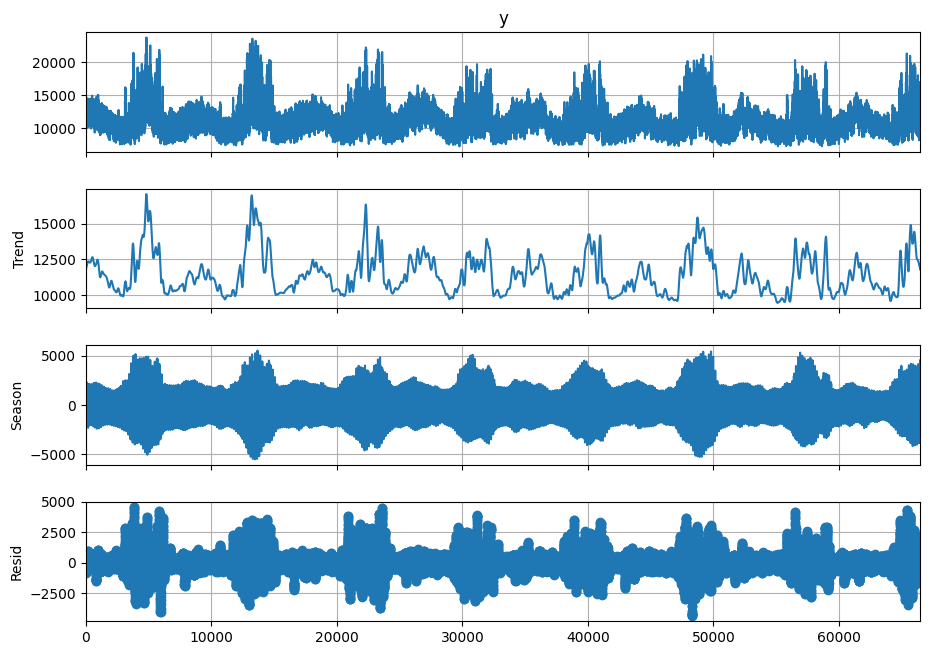

In [25]:
stl_weekly_result = stl_weekly.plot()
stl_weekly_result.set_figwidth(10)
stl_weekly_result.set_figheight(7)

STL is what's left after seasonality. So Weekly structure is strong apart from yearly structure.\
Trend still captures the annual seasonality pattern but doesn't seem to have strong upward or downward trend.\
Residuals still have unmodeled pattern.

> Multiple Seasonal Trend decomposition

In [26]:
# mstl for daily and weekly seasonal
# fourier terms for longer annual periods
mstl = MSTL(df['y'], periods=[24, 168], stl_kwargs={'robust': True})
mstl_result = mstl.fit()

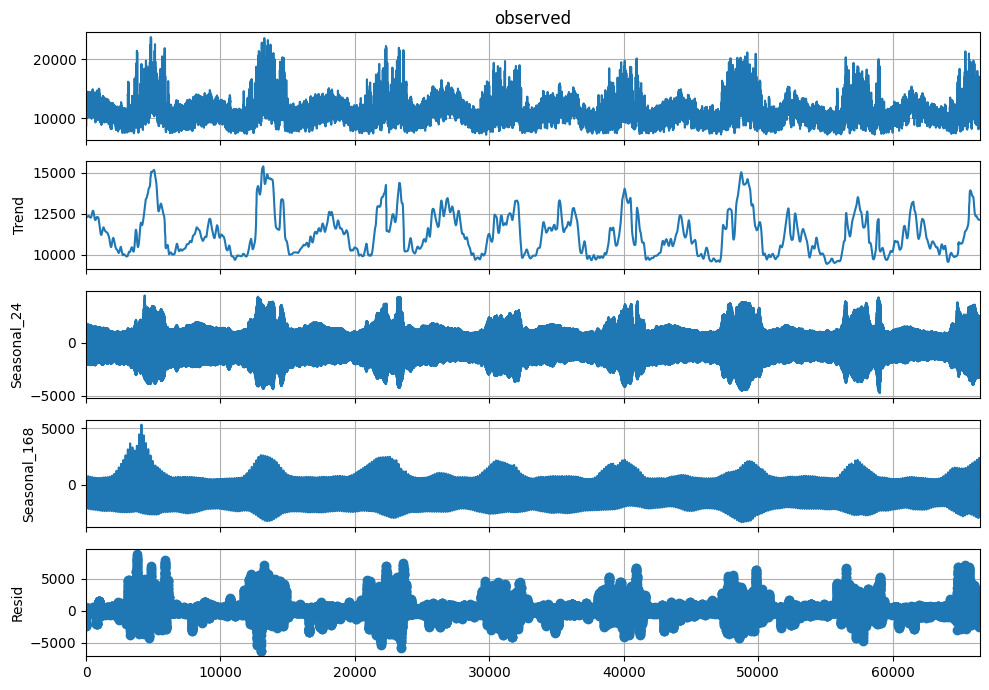

In [27]:
fig = mstl_result.plot()
fig.set_size_inches(10, 7)
plt.tight_layout()
plt.show()

- Trend baseline is slowly declining over the years
- Daily patterns changes overtime
- Weekdays used to consume more electricity but the spread shifted overtime
- Residuals are clearly not whitenoise

The residual mixes annual seasonality leakage with real volatility.\
log1p reduces this variance inflation <strong>(heteroskedasticity)</strong> so MSTL and statistical models behave as intended

ACF and PACF plots analysis for ARIMA

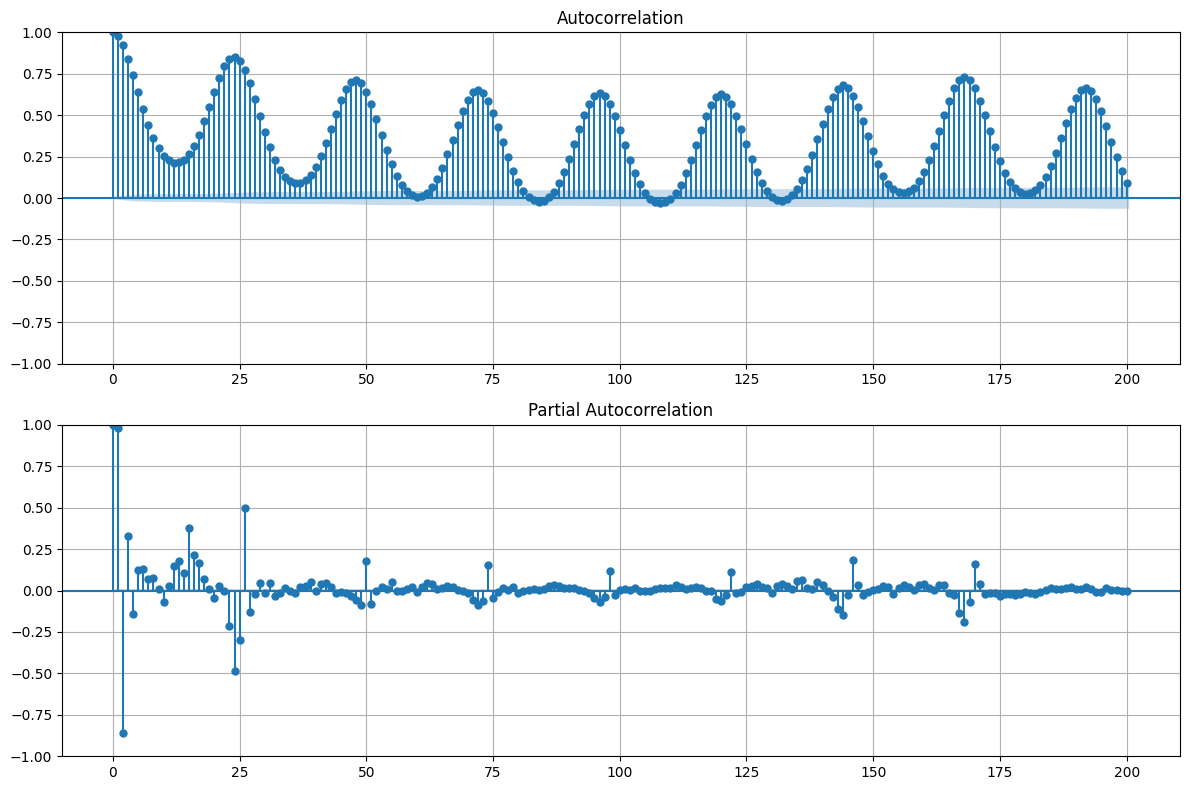

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# lags=200 covers 8 full daily cycles enough room to oberve weekly spikes
plot_acf(df['y'], lags=200, ax=axes[0])
plot_pacf(df['y'], lags=200, ax=axes[1])

plt.tight_layout()
plt.show()

#ACF Findings

Very Strong daily patterns (every 24 lags) and amplitudes are barely decaying.\
The daily seasonality are highly correlated and long-memory.\
The series is non-stationary and needs differencing.

#PACF Findings

The PACF exhibits a strong spike at lag 1 and a clear cutoff after a prominent spike at lag 24, consistent with a seasonal AR(1) structure at the daily period.

In [29]:
df['y_log'] = np.log1p(df['y'])
df.head()

,ds,unique_id,y,y_log
0,2011-01-01 01:00:00,comed_hourly,9631.0,9.172846
1,2011-01-01 02:00:00,comed_hourly,9273.0,9.134970
2,2011-01-01 03:00:00,comed_hourly,9011.0,9.106312
3,2011-01-01 04:00:00,comed_hourly,8741.0,9.075894
4,2011-01-01 05:00:00,comed_hourly,8694.0,9.070503


### Train Test split

In [30]:
# use last 14 days as test set (336 hours)
test_size = 24 * 14
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]
test = test.drop(columns=['y_log'])

print(f"Train: {train['ds'].min()} to {train['ds'].max()} — {len(train)} rows")
print(f"Test:  {test['ds'].min()} to {test['ds'].max()} — {len(test)} rows")

Train: 2011-01-01 01:00:00 to 2018-07-20 00:00:00 — 66168 rows
Test:  2018-07-20 01:00:00 to 2018-08-03 00:00:00 — 336 rows


In [31]:
train_log_scaled = train[['unique_id', 'ds', 'y_log']].rename(columns={'y_log': 'y'})

Baselines

In [32]:
forecast_horizon = 336 # 14 days

daily_seasonal_length = 24  # daily
weekly_seasonal_length = 168

frequency = 'h' # hourly


sf_baseline = StatsForecast(
    models=[
        Naive(),
        HistoricAverage(),
        RandomWalkWithDrift(),
        SeasonalNaive(season_length=daily_seasonal_length, alias='SeasonalNaive_Daily'),
        SeasonalNaive(season_length=weekly_seasonal_length, alias='SeasonalNaive_Weekly')
    ],
    freq=frequency,
)

sf_baseline.fit(train_log_scaled)

forecast_baseline_train = sf_baseline.predict(h=forecast_horizon)
forecast_baseline_train

,unique_id,ds,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-07-20 01:00:00,9.521202,9.324101,9.521207,9.313799,9.499871
1,comed_hourly,2018-07-20 02:00:00,9.521202,9.324101,9.521212,9.243001,9.417111
2,comed_hourly,2018-07-20 03:00:00,9.521202,9.324101,9.521218,9.189321,9.360397
3,comed_hourly,2018-07-20 04:00:00,9.521202,9.324101,9.521223,9.150909,9.312626
4,comed_hourly,2018-07-20 05:00:00,9.521202,9.324101,9.521228,9.128045,9.278933
...,...,...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,9.521202,9.324101,9.522950,9.627207,9.627207
332,comed_hourly,2018-08-02 21:00:00,9.521202,9.324101,9.522955,9.607773,9.607773
333,comed_hourly,2018-08-02 22:00:00,9.521202,9.324101,9.522960,9.597642,9.597642
334,comed_hourly,2018-08-02 23:00:00,9.521202,9.324101,9.522965,9.581628,9.581628


In [33]:
cv_baseline_df = sf_baseline.cross_validation(
    h = forecast_horizon,
    df = train_log_scaled,
    n_windows = 5,   # 5 folds
    step_size = forecast_horizon
)

#Rescale before evaluation

In [34]:
# expm1 all value columns before evaluation
cols_to_transform = ['y', 'Naive', 'HistoricAverage', 'RWD', 'SeasonalNaive_Daily', 'SeasonalNaive_Weekly']

cv_df_baseline_orig = cv_baseline_df.copy()
cv_df_baseline_orig[cols_to_transform] = np.expm1(cv_baseline_df[cols_to_transform])

cv_df_baseline_orig.head()

,unique_id,ds,cutoff,y,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-05-11 01:00:00,2018-05-11,9118.0,9897.0,11184.387445,9897.004181,9804.0,9408.0
1,comed_hourly,2018-05-11 02:00:00,2018-05-11,8542.0,9897.0,11184.387445,9897.008363,9093.0,8913.0
2,comed_hourly,2018-05-11 03:00:00,2018-05-11,8192.0,9897.0,11184.387445,9897.012544,8671.0,8616.0
3,comed_hourly,2018-05-11 04:00:00,2018-05-11,7959.0,9897.0,11184.387445,9897.016725,8397.0,8440.0
4,comed_hourly,2018-05-11 05:00:00,2018-05-11,7895.0,9897.0,11184.387445,9897.020907,8267.0,8361.0


In [35]:
eval_baseline_res = evaluate(
    cv_df_baseline_orig,
    metrics=[rmse, mae],
    models=['Naive', 'HistoricAverage', 'RWD', 'SeasonalNaive_Daily', 'SeasonalNaive_Weekly']
)

eval_baseline_res

,unique_id,cutoff,metric,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-05-11,rmse,1573.317034,2021.805051,1573.188552,1251.752293,783.918040
1,comed_hourly,2018-05-25,rmse,2640.428476,2802.699306,2641.604994,1893.598125,2851.622210
2,comed_hourly,2018-06-08,rmse,3185.315850,3103.840225,3182.841666,2317.793020,3077.931451
3,comed_hourly,2018-06-22,rmse,4358.487092,4001.752031,4356.043976,3570.158116,3294.612570
4,comed_hourly,2018-07-06,rmse,2937.199625,3824.352253,2938.778844,2476.430247,2913.137095
5,comed_hourly,2018-05-11,mae,1342.303571,1685.648036,1342.287540,888.071429,526.529762
6,comed_hourly,2018-05-25,mae,2225.345238,2244.465194,2227.084897,1590.767857,2168.071429
7,comed_hourly,2018-06-08,mae,2385.392857,2332.843730,2383.567339,1704.011905,2234.916667
8,comed_hourly,2018-06-22,mae,3407.625000,3109.863877,3405.482175,2756.482143,2751.232143
9,comed_hourly,2018-07-06,mae,2479.023810,3066.007965,2479.729913,1936.738095,2258.523810


In [36]:
eval_baseline_res[eval_baseline_res['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

SeasonalNaive_Daily     2301.946360
SeasonalNaive_Weekly    2584.244273
RWD                     2938.491606
Naive                   2938.949615
HistoricAverage         3150.889773
dtype: float64

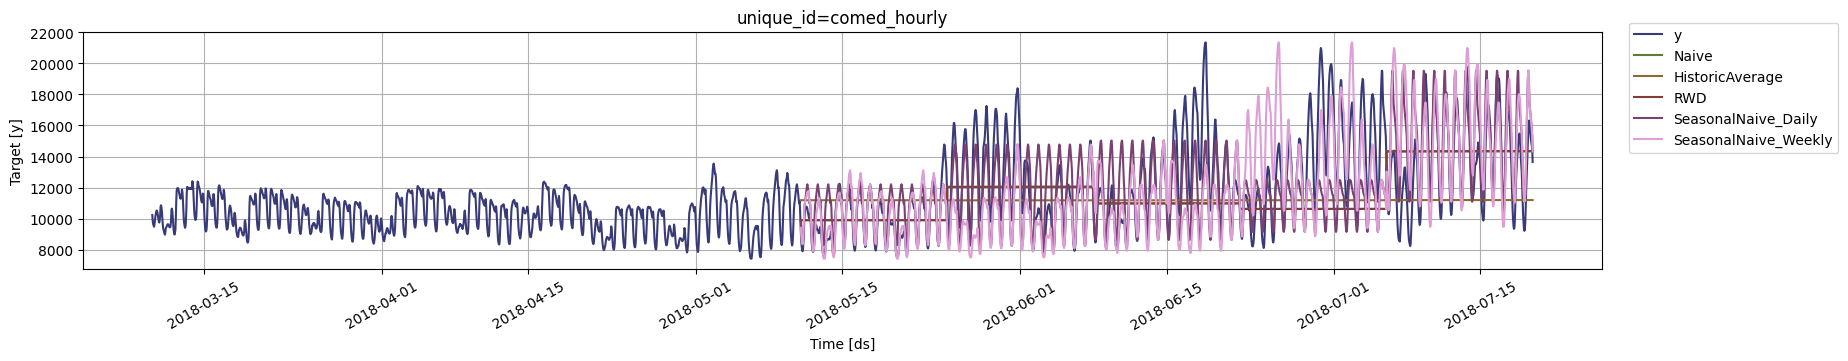

In [ ]:
StatsForecast.plot(
    train[63000:],
    cv_df_baseline_orig[
        [
            'unique_id', 'ds', 
            'Naive', 'HistoricAverage', 'RWD', 
            'SeasonalNaive_Weekly'
            'SeasonalNaive_Daily', 
        ]
    ]
)

#Statistical Models

In [38]:
forecast_horizon = 336 # 14 days

daily_seasonal_length = 24  # daily
weekly_seasonal_length = 168

frequency = 'h' # hourly


sf = StatsForecast(
    models=[
        # AutoARIMA(season_length=daily_seasonal_length),
        ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 1), season_length=daily_seasonal_length, alias="SARIMA_211_111_24"),
        AutoETS(season_length=daily_seasonal_length),
        MSTL_Model(
            season_length=[24, 168],
        ),
        # AutoTBATS(
        #     season_length=[24, 168]
        # )
    ],
    freq=frequency,
    n_jobs=-1
)

sf.fit(train_log_scaled)

forecast_train = sf.predict(h=forecast_horizon)
forecast_train

,unique_id,ds,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,2018-07-20 01:00:00,9.440399,9.416514,9.431105
1,comed_hourly,2018-07-20 02:00:00,9.367914,9.346840,9.354619
2,comed_hourly,2018-07-20 03:00:00,9.310196,9.291387,9.297156
3,comed_hourly,2018-07-20 04:00:00,9.267236,9.250096,9.254228
4,comed_hourly,2018-07-20 05:00:00,9.242527,9.225626,9.230911
...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,9.866959,9.663371,9.730113
332,comed_hourly,2018-08-02 21:00:00,9.827136,9.631874,9.693638
333,comed_hourly,2018-08-02 22:00:00,9.793362,9.609177,9.662172
334,comed_hourly,2018-08-02 23:00:00,9.763161,9.582254,9.631440


In [39]:
cv_df = sf.cross_validation(
    h = forecast_horizon,
    df = train_log_scaled,
    n_windows = 5,   # 5 folds
    step_size = forecast_horizon
)

In [40]:
# expm1 all value columns before evaluation
cols_to_transform = ['y', 'SARIMA_211_111_24', 'AutoETS', 'MSTL']

cv_df_orig = cv_df.copy()
cv_df_orig[cols_to_transform] = np.expm1(cv_df[cols_to_transform])

cv_df_orig.head()

,unique_id,ds,cutoff,y,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,2018-05-11 01:00:00,2018-05-11,9118.0,9119.552128,9014.637119,9184.592432
1,comed_hourly,2018-05-11 02:00:00,2018-05-11,8542.0,8542.994053,8453.266450,8621.473438
2,comed_hourly,2018-05-11 03:00:00,2018-05-11,8192.0,8187.101858,8126.861525,8260.577739
3,comed_hourly,2018-05-11 04:00:00,2018-05-11,7959.0,7960.598112,7931.588313,8036.564962
4,comed_hourly,2018-05-11 05:00:00,2018-05-11,7895.0,7871.457642,7873.176223,7941.377794


In [41]:
eval_res = evaluate(
    cv_df_orig,
    metrics=[rmse, mae],
    models=['SARIMA_211_111_24', 'AutoETS', 'MSTL']
)

eval_res

,unique_id,cutoff,metric,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,2018-05-11,rmse,1350.586220,1174.803102,720.389047
1,comed_hourly,2018-05-25,rmse,5740.538659,2111.356061,1926.436582
2,comed_hourly,2018-06-08,rmse,2577.207524,2510.610791,3044.788620
3,comed_hourly,2018-06-22,rmse,5535.163112,3717.958328,3238.003042
4,comed_hourly,2018-07-06,rmse,1941.096622,1918.396338,1789.856537
5,comed_hourly,2018-05-11,mae,1064.738042,802.719089,473.284739
6,comed_hourly,2018-05-25,mae,4454.925651,1747.754378,1519.489689
7,comed_hourly,2018-06-08,mae,1900.964236,1814.865656,2050.577649
8,comed_hourly,2018-06-22,mae,4595.849018,3059.165384,2471.054828
9,comed_hourly,2018-07-06,mae,1530.226191,1478.020638,1427.726608


In [42]:
eval_res[eval_res['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

MSTL                 2143.894765
AutoETS              2286.624924
SARIMA_211_111_24    3428.918427
dtype: float64

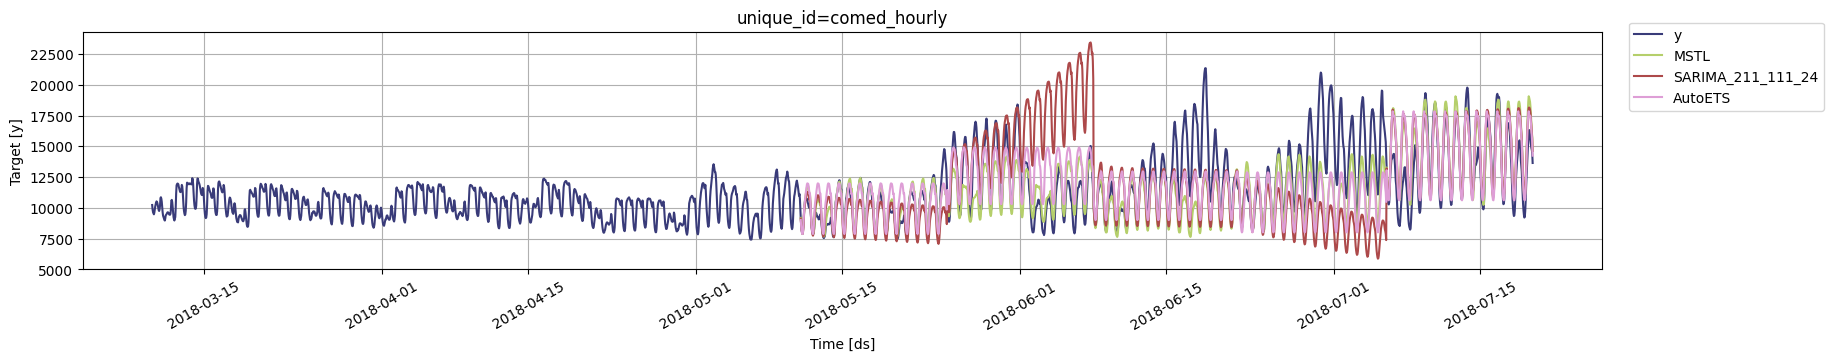

In [43]:
StatsForecast.plot(
    train[63000:],
    cv_df_orig[
        [
            'unique_id', 'ds', 
            'MSTL',
            'SARIMA_211_111_24', 
            'AutoETS',
        ]
    ]
)

### Evaluation

In [44]:
baseline_model_cols = ['Naive', 'HistoricAverage', 'RWD', 'SeasonalNaive_Daily', 'SeasonalNaive_Weekly']
stat_model_cols = ['SARIMA_211_111_24', 'AutoETS', 'MSTL']
all_model_cols = baseline_model_cols + stat_model_cols

In [45]:
baseline = forecast_baseline_train.copy()
stat_models = forecast_train.copy()

baseline[baseline_model_cols] = np.expm1(forecast_baseline_train[baseline_model_cols])
stat_models[stat_model_cols] = np.expm1(forecast_train[stat_model_cols])

In [46]:
forecast_all = stat_models[['unique_id', 'ds'] + stat_model_cols].merge(
    baseline[['unique_id', 'ds'] + baseline_model_cols],
    on=['unique_id', 'ds'],
    how='inner'
)

forecast_all.head()

,unique_id,ds,SARIMA_211_111_24,AutoETS,MSTL,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-07-20 01:00:00,12585.741222,12288.665540,12469.299581,13645.0,11203.84334,13645.071844,11089.0,13357.0
1,comed_hourly,2018-07-20 02:00:00,11705.664970,11461.549333,11551.060932,13645.0,11203.84334,13645.143687,10331.0,12296.0
2,comed_hourly,2018-07-20 03:00:00,11049.110572,10843.219438,10905.954745,13645.0,11203.84334,13645.215532,9791.0,11618.0
3,comed_hourly,2018-07-20 04:00:00,10584.454021,10404.560556,10447.645502,13645.0,11203.84334,13645.287376,9422.0,11076.0
4,comed_hourly,2018-07-20 05:00:00,10326.099274,10153.034504,10206.838322,13645.0,11203.84334,13645.359222,9209.0,10709.0


In [47]:
eval_df = test.merge(
    forecast_all,
    on=['unique_id', 'ds'],
    how='left'
)

eval_df.head()


,ds,unique_id,y,SARIMA_211_111_24,AutoETS,MSTL,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,2018-07-20 01:00:00,comed_hourly,12682.0,12585.741222,12288.665540,12469.299581,13645.0,11203.84334,13645.071844,11089.0,13357.0
1,2018-07-20 02:00:00,comed_hourly,11929.0,11705.664970,11461.549333,11551.060932,13645.0,11203.84334,13645.143687,10331.0,12296.0
2,2018-07-20 03:00:00,comed_hourly,11327.0,11049.110572,10843.219438,10905.954745,13645.0,11203.84334,13645.215532,9791.0,11618.0
3,2018-07-20 04:00:00,comed_hourly,10895.0,10584.454021,10404.560556,10447.645502,13645.0,11203.84334,13645.287376,9422.0,11076.0
4,2018-07-20 05:00:00,comed_hourly,10676.0,10326.099274,10153.034504,10206.838322,13645.0,11203.84334,13645.359222,9209.0,10709.0


In [48]:
final_eval_res = evaluate(
    eval_df,
    metrics=[mae, rmse],
    models=all_model_cols
)

final_eval_res

,unique_id,metric,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,mae,2265.919643,2088.059641,2269.639404,1281.848214,2164.770833,3120.868863,1510.665218,1717.479344
1,comed_hourly,rmse,2673.405438,2610.644983,2678.620656,1703.781918,2665.489443,3518.010306,1909.531132,1996.744791


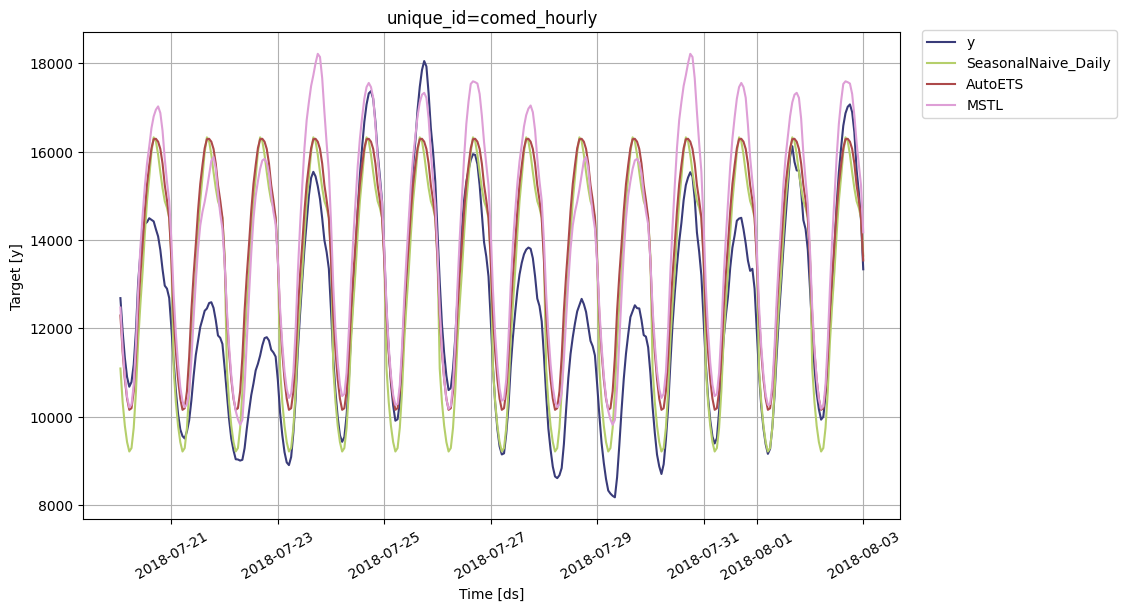

In [49]:
f = sf.plot(
    test,
    forecast_all,
    models=[
        'SeasonalNaive_Daily', 
        'AutoETS', 
        'MSTL',
    ]
)
f.set_figwidth(9)
f.set_figheight(6)
f

- AutoETL becomes seasonal naive
- MSTL over predicts
- SeasonalNaive_Daily fits the best in here